# NSGA-II experiment

In [1]:
import array
import random

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from deap import creator
from deap import base
from deap import tools
from deap.benchmarks.tools import hypervolume

import nsgaii.price as pr
import nsgaii.objectives as obj
import nsgaii.toolbox as tb
import nsgaii.search as sr
from nsgaii.battery import Battery

In [15]:
def get_results(pop, toolbox):
    results = np.array([toolbox.evaluate(x) for x in pop])

    x = np.hstack([results, pop])
    filtered = x
    filtered = x[np.where(x[:,2] <= 0.5)[0]]
    
    return filtered

def set_labels(ax):
    ax.set_xlabel('Hour of a day $[h]$')
    ax.set_ylabel('Consumption $[kWh]$')
    ax.set_ylim(0,5)
    ax.set_xlim(0,24)

def filter_and_visualize_results(pop, toolbox, logbook, actual, mape=300):
    filtered = get_results(pop, toolbox)
    
    filtered = filtered[np.where(filtered[:,1] <= mape)[0]]
    
    lowest_price = filtered[filtered[:,0].argmin(),:]
    lowest_mape  = filtered[filtered[:,1].argmin(),:]
    
    

    filtered_pop = filtered[:,3:]
    filtered_results = filtered[:,0:3]

    



    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2,figsize=(10,8))
    for solution in filtered_pop:
        ax1.plot(solution)

    ax1.set_title('All filtered solutions')
    set_labels(ax1)
    
    ax2.set_title('Marginal solutions')    
    ax2.plot(lowest_price[3:], label='lowest price')
    ax2.plot(lowest_mape[3:], label='lowest mape')
    ax2.plot(actual, label='actual')
    set_labels(ax2)
    ax2.legend(loc=2, prop={'size': 10})
    

    ax3.set_title('Distribution of solutions')
    ax3.scatter(filtered_results[:,0], filtered_results[:,1])
    ax3.set_xlabel('Cost of electricity $[\$]$')
    ax3.set_ylabel('MAPE $[\%]$')
    ax3.set_ylim(0,mape)
    ax3.set_xlim(0,1)
    
    ax4.set_title('Hypervolume')
    ax4.plot(logbook.select('hypervolume'))
    ax4.set_xlabel('Generations')
    ax4.set_ylabel('Hypervolume')
    
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    
    print('Number of solutions: %d'%len(filtered))
    print('Lowest price solution: cost %f, MAPE %f, diff %f'%(lowest_price[0], lowest_price[1], lowest_price[2]))
    print('Lowest MAPE  solution: cost %f, MAPE %f, diff %f'%(lowest_mape[0], lowest_mape[1], lowest_mape[2]))
    print('Price of predicted solution: %f'%obj.cost_function(actual, pv, None, actual)[0])

In [3]:
creator.create('FitnessMin', base.Fitness, weights=(-1.0, -1.0, -1.0))
creator.create('Individual', array.array, typecode='d', fitness=creator.FitnessMin)

In [6]:
# dimenzionalita problemu, AKA pocet dimenzii
NDIM = 24
BOUND_LOW = 0
BOUND_UP = 10
GENS = 200
POPULATION_SIZE = 200

# Recommendation for average winter day

In [7]:
df = pd.read_csv('aggregations/average_winter_day.csv', delimiter=',')
actual = df['use'].as_matrix()
pv   = df['gen'].as_matrix()
print('Price of predicted solution: %f'%obj.cost_function(actual, pv, None, actual)[0])

Price of predicted solution: 0.801744


In [8]:
%%time

# first of all, no battery
toolbox_wob = tb.setup(actual, pv, NDIM, BOUND_LOW, BOUND_UP)
pop_wob, logbook_wob = sr.search(toolbox_wob, gens=GENS, verbose=False)

# battery with 3 kWh
battery = Battery(3,0)
toolbox_b_3 = tb.setup(actual, pv, NDIM, BOUND_LOW, BOUND_UP, battery)
pop_b_3, logbook_b_3 = sr.search(toolbox_b_3, gens=GENS, verbose=False)

# battery with 5 kWh
battery = Battery(5,0)
toolbox_b_5 = tb.setup(actual, pv, NDIM, BOUND_LOW, BOUND_UP, battery)
pop_b_5, logbook_b_5 = sr.search(toolbox_b_5, gens=GENS, verbose=False)

Wall time: 27.1 s


## Average winter day - no battery

Number of solutions: 22
Lowest price solution: cost 0.338418, MAPE 390.795342, diff 0.472127
Lowest MAPE  solution: cost 0.724293, MAPE 16.549493, diff 0.000001
Price of predicted solution: 0.801744


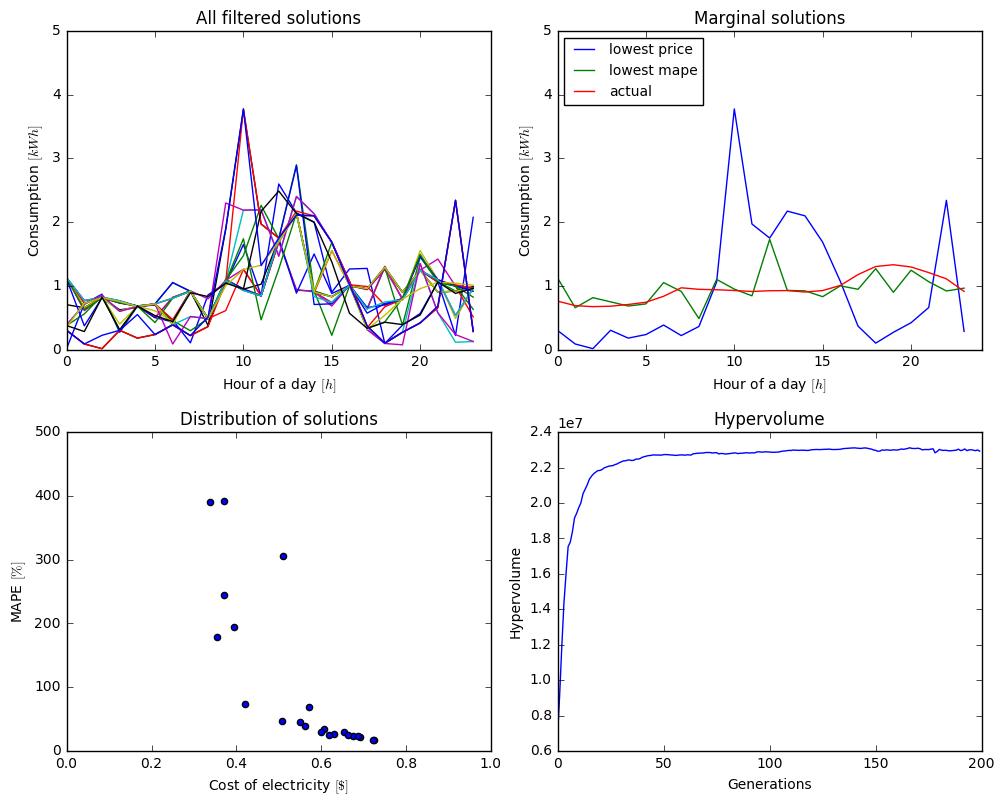

In [21]:
filter_and_visualize_results(pop_wob, toolbox_wob, logbook_wob, actual, mape=500)
plt.savefig('winter day no battery.jpg', dpi=500)

## Average winter day - 3kWh battery

Number of solutions: 42
Lowest price solution: cost 0.292139, MAPE 133.037939, diff 0.440295
Lowest MAPE  solution: cost 0.489951, MAPE 10.305407, diff 0.074300
Price of predicted solution: 0.801744


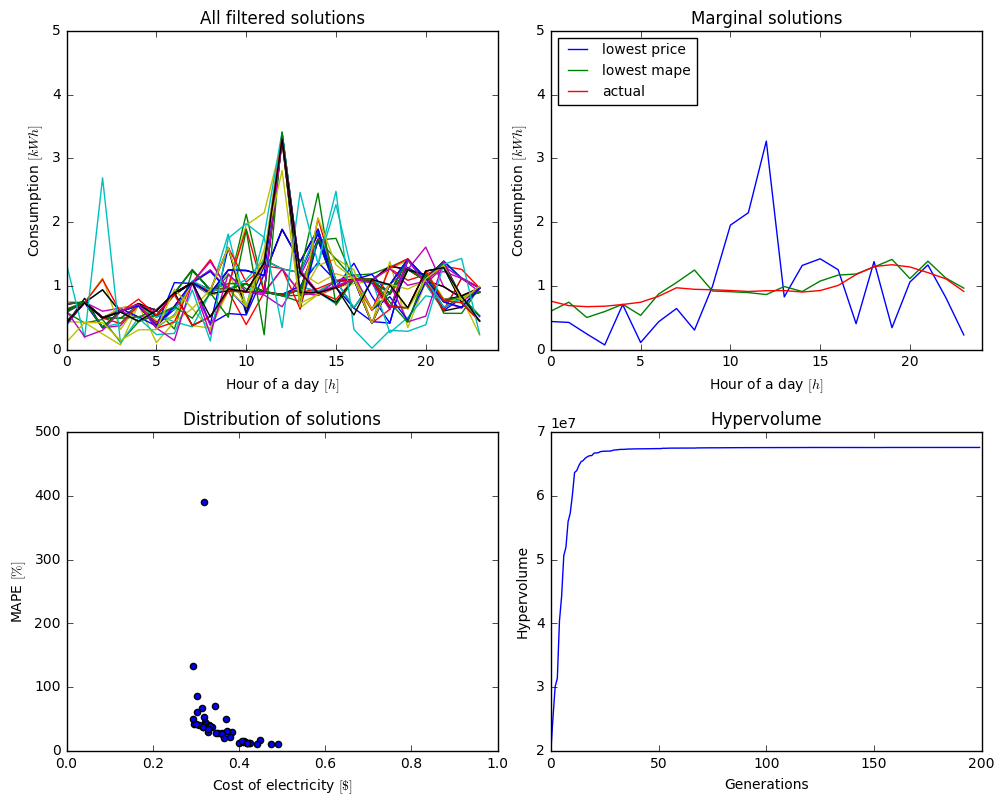

In [19]:
filter_and_visualize_results(pop_b_3, toolbox_b_3, logbook_b_3, actual, mape=500)

## Average winter day - 5kWh battery

Number of solutions: 65
Lowest price solution: cost 0.296502, MAPE 155.516415, diff 0.303546
Lowest MAPE  solution: cost 0.352753, MAPE 10.055901, diff 0.039242
Price of predicted solution: 0.801744


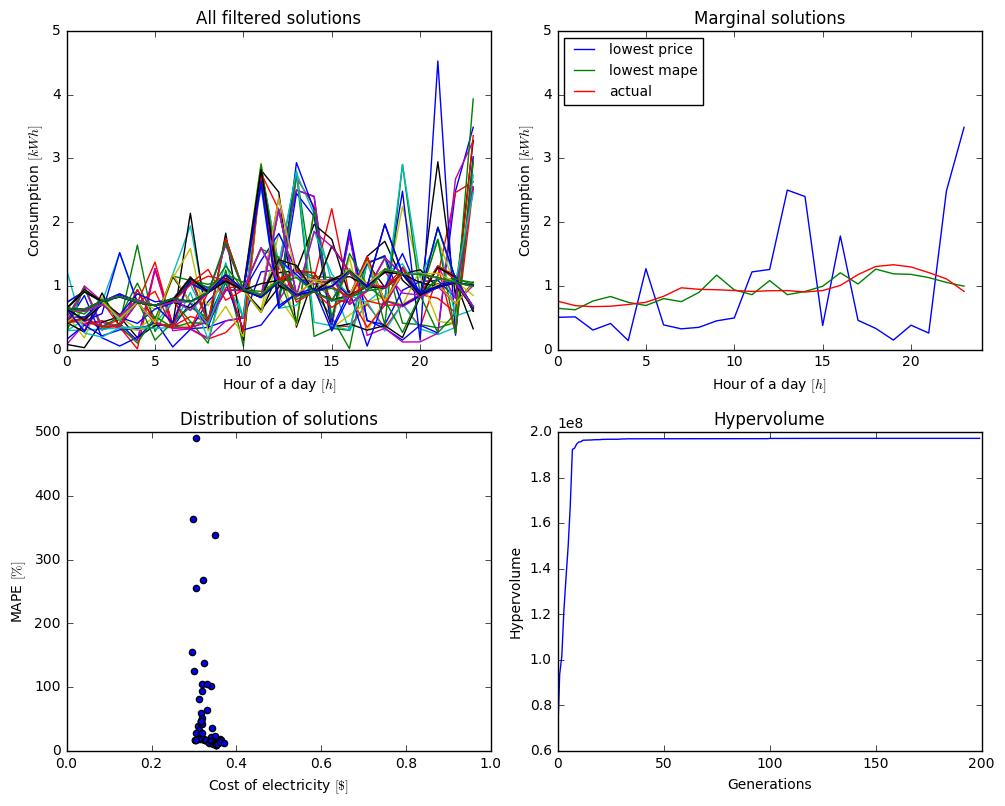

In [20]:
filter_and_visualize_results(pop_b_5, toolbox_b_5, logbook_b_5, actual, mape=500)

In [39]:
def get_averages(toolbox, actual, pv, iterations=10):
    results = []
    
    for i in range(0,iterations):
        print('Iteration: %d'%i)
        pop, logbook = sr.search(toolbox, gens=GENS, verbose=False)
        
        filtered = get_results(pop, toolbox)

        lowest_price = filtered[filtered[:,0].argmin(),:]        
        
        results.append([lowest_price[0], lowest_price[1]])
    
    return np.array(results)

toolbox_wob = tb.setup(actual, pv, NDIM, BOUND_LOW, BOUND_UP, None)
results = get_averages(toolbox_wob, actual, pv)
print('No battery')
print('Mean', results.mean(axis=0).tolist())
print('Std', results.std(axis=0).tolist())

# battery with 3 kWh
battery = Battery(3,0)
toolbox_b3 = tb.setup(actual, pv, NDIM, BOUND_LOW, BOUND_UP, battery)
results = get_averages(toolbox_b3, actual, pv)
print('3kWh battery')
print('Mean', results.mean(axis=0).tolist())
print('Std', results.std(axis=0).tolist())

# battery with 5 kWh
battery = Battery(5,0)
toolbox_b5 = tb.setup(actual, pv, NDIM, BOUND_LOW, BOUND_UP, battery)
results = get_averages(toolbox_b5, actual, pv)

print('5kWh battery')
print('Mean', results.mean(axis=0).tolist())
print('Std', results.std(axis=0).tolist())

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
No battery
Mean [0.3164856987042191, 28165785340.32023]
Std [0.01696109367881235, 47951141659.04868]
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
3kWh battery
Mean [0.294220707479226, 2176.073750549188]
Std [0.006592746379872371, 4382.7398717002425]
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
5kWh battery
Mean [0.2796481455346682, 628.292481992819]
Std [0.020359819550118303, 949.7759642346516]


In [30]:
results.mean(axis=0).tolist()

[0.3208139093501034, 27373966.372170724]

# Recommendation for average summer day

In [42]:
df = pd.read_csv('aggregations/average_summer_day.csv', delimiter=',')
actual = df['use'].as_matrix()
pv   = df['gen'].as_matrix()
print('Price of predicted solution: %f'%obj.cost_function(actual, pv, None, actual)[0])

Price of predicted solution: 1.271188


In [43]:
def get_averages(toolbox, actual, pv, iterations=10):
    results = []
    
    for i in range(0,iterations):
        print('Iteration: %d'%i)
        pop, logbook = sr.search(toolbox, gens=GENS, verbose=False)
        
        filtered = get_results(pop, toolbox)

        lowest_price = filtered[filtered[:,0].argmin(),:]        
        
        results.append([lowest_price[0], lowest_price[1]])
    
    return np.array(results)

toolbox_wob = tb.setup(actual, pv, NDIM, BOUND_LOW, BOUND_UP, None)
results = get_averages(toolbox_wob, actual, pv)
print('No battery')
print('Mean', results.mean(axis=0).tolist())
print('Std', results.std(axis=0).tolist())

# battery with 3 kWh
battery = Battery(3,0)
toolbox_b3 = tb.setup(actual, pv, NDIM, BOUND_LOW, BOUND_UP, battery)
results = get_averages(toolbox_b3, actual, pv)
print('3kWh battery')
print('Mean', results.mean(axis=0).tolist())
print('Std', results.std(axis=0).tolist())

# battery with 5 kWh
battery = Battery(5,0)
toolbox_b5 = tb.setup(actual, pv, NDIM, BOUND_LOW, BOUND_UP, battery)
results = get_averages(toolbox_b5, actual, pv)

print('5kWh battery')
print('Mean', results.mean(axis=0).tolist())
print('Std', results.std(axis=0).tolist())

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
No battery
Mean [0.68818622409075, 40543.2140476097]
Std [0.014072829467949443, 49135.61093596827]
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
3kWh battery
Mean [0.660858036869652, 7889.319776535567]
Std [0.009545915810218308, 18159.220178664174]
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
5kWh battery
Mean [0.6541649279626134, 2246410.8072733684]
Std [0.0195537971454634, 6092780.204902754]


In [11]:
%%time

# first of all, no battery
toolbox_wob = tb.setup(actual, pv, NDIM, BOUND_LOW, BOUND_UP)
pop_wob, logbook_wob = sr.search(toolbox_wob, gens=GENS, verbose=False)

# battery with 3 kWh
battery = Battery(3,0)
toolbox_b_3 = tb.setup(actual, pv, NDIM, BOUND_LOW, BOUND_UP, battery)
pop_b_3, logbook_b_3 = sr.search(toolbox_b_3, gens=GENS, verbose=False)

# battery with 5 kWh
battery = Battery(5,0)
toolbox_b_5 = tb.setup(actual, pv, NDIM, BOUND_LOW, BOUND_UP, battery)
pop_b_5, logbook_b_5 = sr.search(toolbox_b_5, gens=GENS, verbose=False)

Wall time: 20.9 s


## Average summer day - no battery

Number of solutions: 15
Lowest price solution: cost 0.715911, MAPE 271.438437, diff 0.454937
Lowest MAPE  solution: cost 0.936019, MAPE 41.033882, diff 0.224494
Price of predicted solution: 1.271188


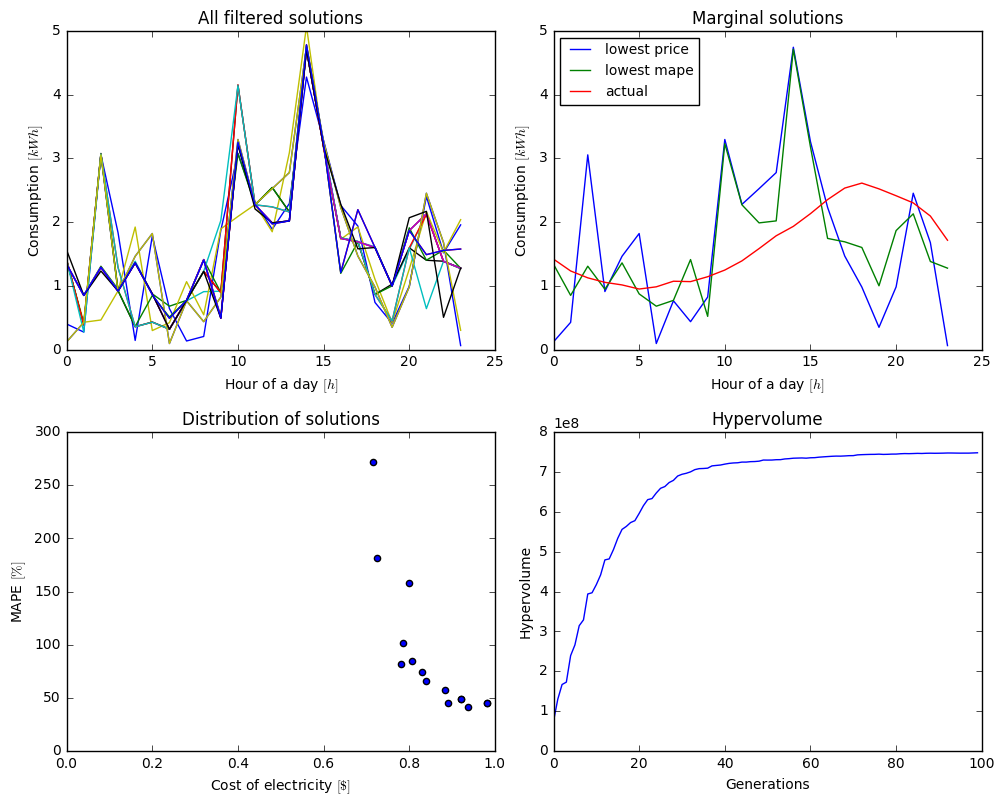

In [12]:
filter_and_visualize_results(pop_wob, toolbox_wob, logbook_wob, actual)

## Average summer day - 3kWh battery

Number of solutions: 9
Lowest price solution: cost 0.662764, MAPE 6326.779081, diff 0.318551
Lowest MAPE  solution: cost 0.783004, MAPE 39.497306, diff 0.092446
Price of predicted solution: 1.271188


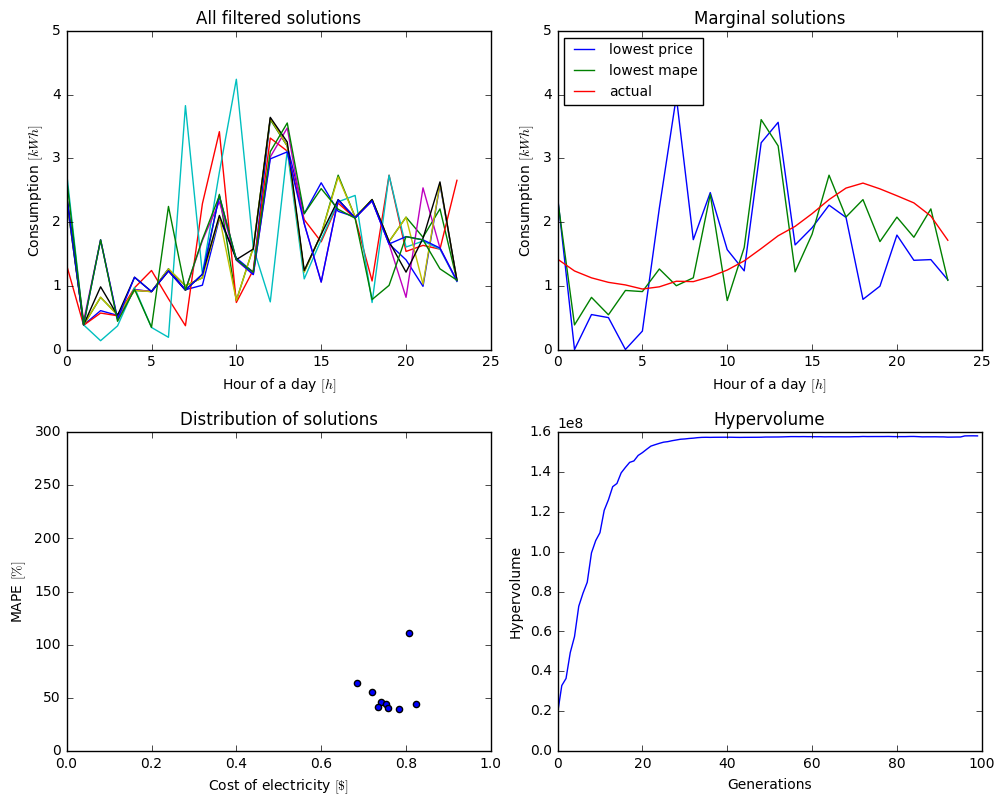

In [13]:
filter_and_visualize_results(pop_b_3, toolbox_b_3, logbook_b_3, actual)

## Average summer day - 5 kWh battery

Number of solutions: 9
Lowest price solution: cost 0.659442, MAPE 25.944939, diff 0.422673
Lowest MAPE  solution: cost 0.697457, MAPE 24.500415, diff 0.001458
Price of predicted solution: 1.271188


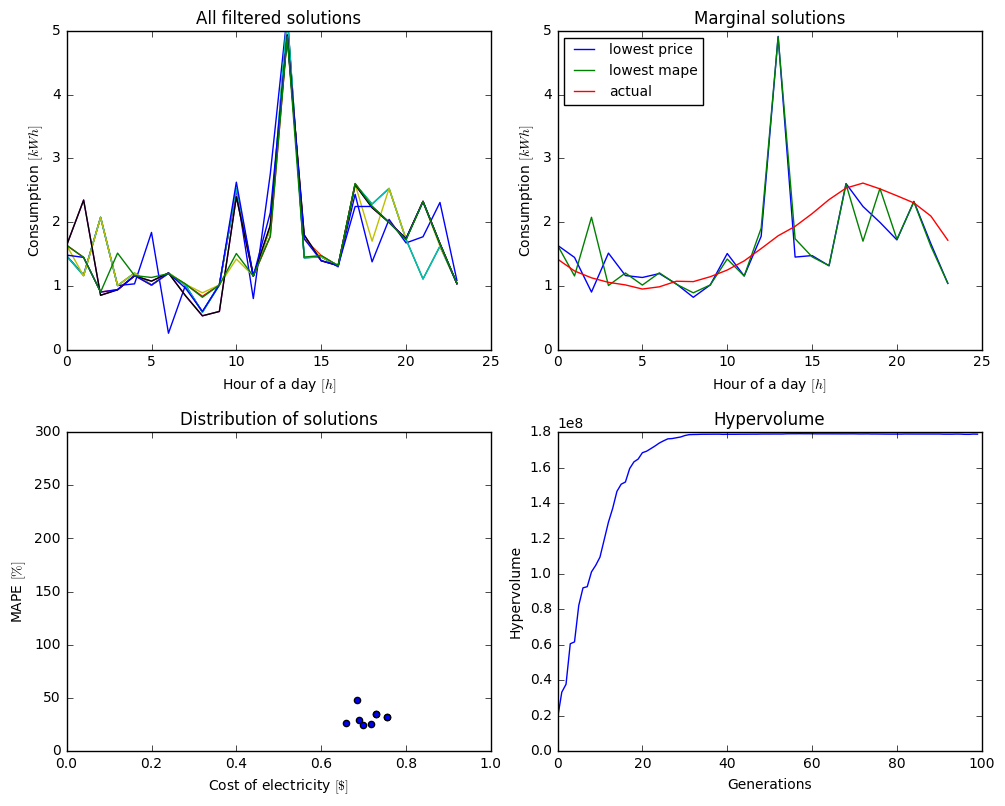

In [14]:
filter_and_visualize_results(pop_b_5, toolbox_b_5, logbook_b_5, actual)